In [1]:
# default_exp learn

In [2]:
#export 
import pandas as pd
from pymongo import MongoClient
from pathlib import Path
import shutil
from mytools.tools import *
from fur.paths import *
from annoy import AnnoyIndex

from fastai.vision.all import *

import nested_lookup
from IPython.display import Image,display

In [3]:
#export
def save_file_from_url(url, fname):
    r = requests.get(url, allow_redirects=True)
    open(fname, 'wb').write(r.content)

In [4]:
#export
def images_df():
    pics_path = ssd_pictures_path
#     pics_path = Path('/home/dima/houzz_parse/PICS')
    mongo_connect = MongoClient('mongodb://localhost:27017')
    mongodb = mongo_connect['houzz']
    cursor =mongodb['FurnitureItem'].find()
    data = list(cursor)
    pics = pd.DataFrame(list(pics_path.ls()),columns=['paths'])
    pics['file_name'] = pics['paths'].apply(lambda x:x.name)
    pics['image'] = pics['file_name'].str.split('_').str[0]
    data_filtered = nested_lookup.nested_delete(data,'url_img_product')
    img_keys = nested_lookup.nested_lookup('url_img_product',data)
    img_keys = [list(item.keys()) for item in img_keys]
    df = pd.json_normalize(data_filtered)
    df.columns = [c.split('.')[1] if len(c.split('.'))>1 else c for c in df.columns ]
    df['image'] = img_keys
    df = df.explode('image')
    df = pics.merge(df,on='image')
    df = df.drop_duplicates('image').reset_index(drop=True)
    df.columns = df.columns.str.lower()
    return df.drop(columns=['file_name','image','_id'])

In [5]:
df = images_df()

In [16]:
dataset_description = df.drop(columns=['paths','url']).drop_duplicates(['category','color','materials','style'])

In [18]:
dataset_description.to_csv('dataset_duplicates_dropped.csv')

In [5]:
#export
def mk_model_dir(learner_name):
    model_name = f'model_{learner_name}_{pd.Timestamp.now()}'
    model_path = models_path/model_name
    if not model_path.is_dir(): model_path.mkdir()
    return model_path

In [89]:
def explode_feature(mapping_df):
    mapping_df['color'] = mapping_df['color'].str.lower()
    mapping_df['color'] = mapping_df['color'].str.split(' ')
    mapping_df = mapping_df.explode('color')
    mapping_df['color'] = mapping_df['color'].str.split('/')
    mapping_df = mapping_df.explode('color')
    color = mapping_df.groupby(['color'])['paths'].count().sort_values(ascending=False)[:50].index
    color = color.drop('light','finish:')
    mapping_df.loc[~mapping_df['color'].isin(color),'color'] = np.nan
    return mapping_df.reset_index().sort_values('color',ascending=False).drop_duplicates('index').reset_index(drop=True)

In [112]:
def clean_images(path):
    failed = verify_images([path/p for p in mapping_df['paths'].tolist()]);failed
    L([path/p for p in failed]).map(Path.unlink);

In [63]:
mapping_df = images_df()

In [38]:
len(mapping_df['style'].unique())

17

In [64]:
mapping_df = mapping_df.sample(100000)

In [72]:
mapping_df.groupby('style')['paths'].count().sort_values()

style
Scandinavian        84
Southwestern       123
Eclectic           152
Craftsman          272
Victorian          304
Asian              657
Mediterranean      767
Beach Style        856
Rustic            1556
Farmhouse         2573
Industrial        4516
Modern            4654
Tropical          5170
Midcentury        8104
Traditional       9394
Transitional     26575
Contemporary     32352
Name: paths, dtype: int64

In [65]:
mapping_df['paths'] = mapping_df['paths'].apply(lambda x:x.name)
mapping_df = mapping_df[['paths','style']]
mapping_df = mapping_df.dropna()
mapping_df.loc[mapping_df.sample(int(len(mapping_df)/5)).index,'is_valid'] = True
mapping_df['is_valid'] = mapping_df['is_valid'].fillna(False)
drop_labels = set(mapping_df[mapping_df['is_valid']==True]['style'])^set(mapping_df[mapping_df['is_valid']==False]['style'])
mapping_df = mapping_df[~mapping_df['style'].isin(drop_labels)]

In [66]:
dls = ImageDataLoaders.from_df(mapping_df, path = ssd_pictures_path, 
                               label_col=1, item_tfms=Resize(224), valid_col='is_valid', 
                               metrics=error_rate)
#                                metrics=partial(accuracy_multi, thresh=0.5),label_delim=',')

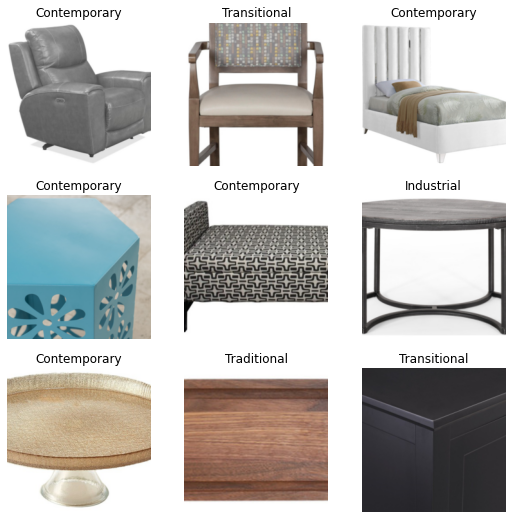

In [67]:
dls.show_batch()

#### learn

In [54]:
#learn = cnn_learner(dls,resnet34, metrics=partial(accuracy_multi, thresh=0.5))

In [55]:
learn = cnn_learner(dls,resnet34, metrics=error_rate)

In [57]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.130617,1.612659,0.460714,00:17


epoch,train_loss,valid_loss,error_rate,time
0,1.149775,1.477781,0.433163,00:21
1,0.767589,1.455128,0.413265,00:21


#### extra train

In [58]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=9.12010818865383e-07)

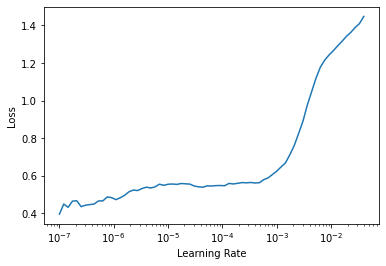

In [59]:
learn.lr_find()

In [61]:
learn.fit_one_cycle(20, slice(2e-6, 1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.503725,1.455026,0.410714,00:22
1,0.499998,1.446709,0.409184,00:21
2,0.511216,1.461673,0.414286,00:21
3,0.485774,1.449549,0.411224,00:21
4,0.467511,1.454583,0.411224,00:21
5,0.450195,1.470997,0.411224,00:21
6,0.404937,1.475560,0.408673,00:21
7,0.388190,1.492920,0.410714,00:21
8,0.370849,1.491461,0.413265,00:21
9,0.356610,1.506969,0.407653,00:21



KeyboardInterrupt



In [73]:
learn.dls = dls

In [74]:
learn.fit_one_cycle(20, slice(2e-6, 1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,1.637718,1.445209,0.396361,03:07
1,1.466141,1.329641,0.384741,03:08
2,1.387850,1.210259,0.366954,03:06
3,1.263426,1.123981,0.351460,03:04
4,1.136072,1.075590,0.338566,03:04
5,1.146314,1.047959,0.331125,03:07
6,1.049723,1.026574,0.323888,03:07
7,1.030165,1.008178,0.317058,03:08
8,0.987011,0.999166,0.315376,03:08
9,0.927570,0.993594,0.312318,03:07


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [76]:
learn.fit_one_cycle(2, slice(2e-6, 1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.744238,0.986334,0.305489,03:06
1,0.704835,0.991221,0.302482,03:06


#### interpret

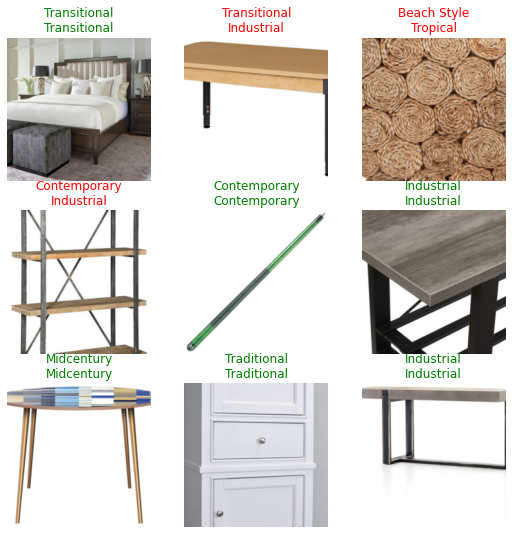

In [77]:
learn.show_results()

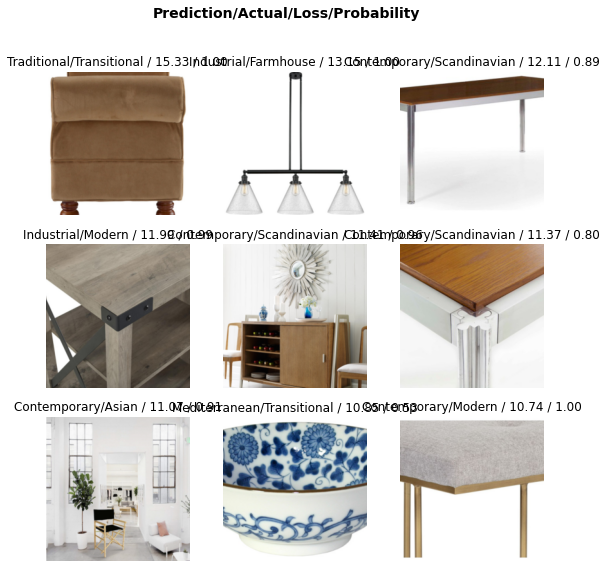

In [78]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

#### save model

In [79]:
model_path = mk_model_dir('furniture_styles_24_11')

In [101]:
model_path

Path('/home/dima/furniture_data/models/model_furniture_styles_24_11_2020-11-24 20:33:21.731581')

In [80]:
learn.export(model_path/'model.pkl')

#### load

In [81]:
models_path/path_info(models_path).sort_values(['time'])['name'].iloc[-1]

Path('/home/dima/furniture_data/models/model_furniture_styles_24_11_2020-11-24 20:33:21.731581')

In [82]:
learn = load_learner(models_path/path_info(models_path).sort_values(['time'])['name'].iloc[-1]/'model.pkl')

In [83]:
learn.dls = dls

### annoy

In [84]:
# export 
# this is a hook (learned about it here: https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903/13)
# hooks are used for saving intermediate computations
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [113]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=17, bias=False)
)

In [140]:
sf = SaveFeatures(learn.model[1][4]) ## Output before the last FC layer

In [141]:
#_= learn.get_preds(ds_idx=0)
_= learn.get_preds(ds_idx=1)

In [142]:
# _= learn.get_preds(ds_idx=1)

In [143]:
len(sf.features)

19621

In [144]:
img_path = [str(x) for x in list(dls.train_ds.items['paths'])];len(img_path)

78488

In [145]:
feature_dict = dict(zip(img_path,sf.features));len(feature_dict)

19621

In [137]:
feature_df = pd.DataFrame()

In [138]:
feature_df['path'] = img_path

In [139]:
feature_df

,path
0,e60115cf0d58cc1d_4-4484.jpg
1,f46176500f5f776b_4-6733.jpg
2,cc818c680c75c46a_4-2226.jpg
3,e451e9870dca7974_4-9867.jpg
4,8a21de8c0e753303_4-2241.jpg
...,...
78483,ecd1286409b9aeeb_4-1169.jpg
78484,38d14e290ed00e80_4-2515.jpg
78485,d841fbef0c75c3ef_4-3651.jpg
78486,3101f5f90f2c88ec_4-6069.jpg


In [ ]:
feature_df['path'] =sf.features

In [146]:
to_pickle(feature_dict,model_path/'feature_dict.pkl')

In [147]:
feature_dim = len(next(iter(feature_dict.values())))
t = AnnoyIndex(feature_dim, metric='euclidean')

for i, vector in enumerate(feature_dict.values()):
    t.add_item(i, vector)

In [148]:
vector.shape

(512,)

In [149]:
t.build(10) # 10 trees

True

In [150]:
t.get_n_items()

19621

In [151]:
t.save(str(model_path/'test.ann'))

True

##### test

In [126]:
similar = t.get_nns_by_vector(sf.features[-1], 1, search_k=-1, include_distances=False)

In [127]:
similar

[78487]

In [128]:
label_df = mapping_df[mapping_df['paths'].isin([list(feature_dict.keys())[i] for i in similar])];label_df

,paths,style,is_valid
264469,683187b00c411138_4-9086.jpg,Contemporary,False


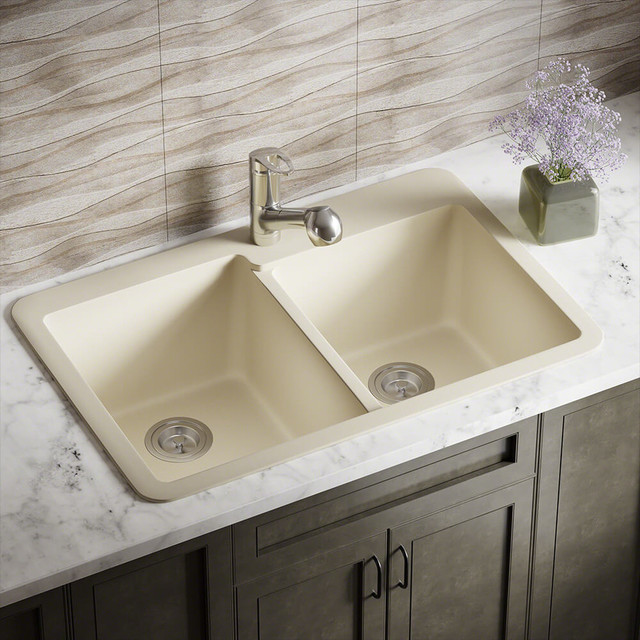

In [100]:
Image(ssd_pictures_path/list(feature_dict.keys())[similar[0]])

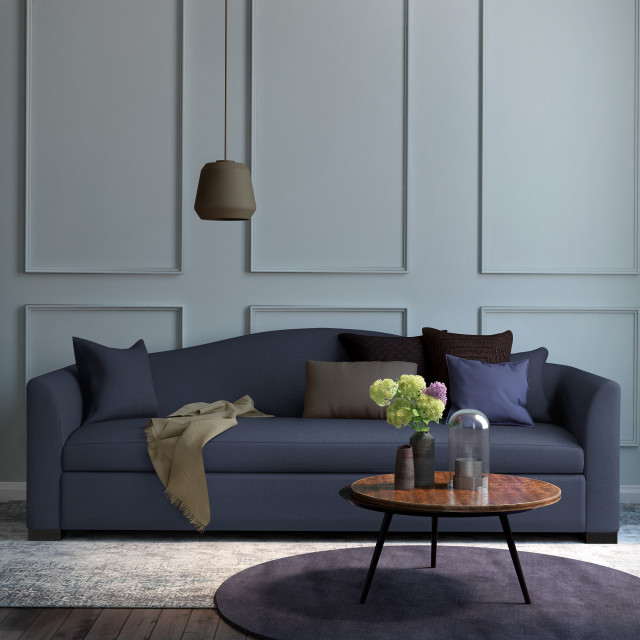

In [790]:
for i in similar:
    display(Image(filename =ssd_pictures_path/list(feature_dict.keys())[i], width=500, height=500))

In [776]:
i

4025

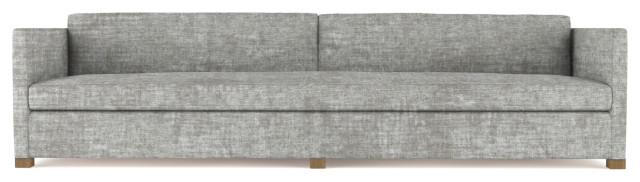

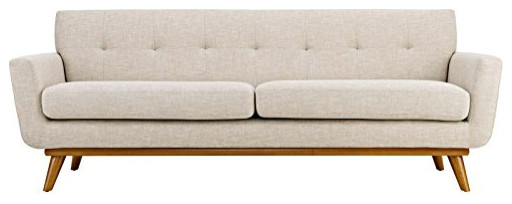

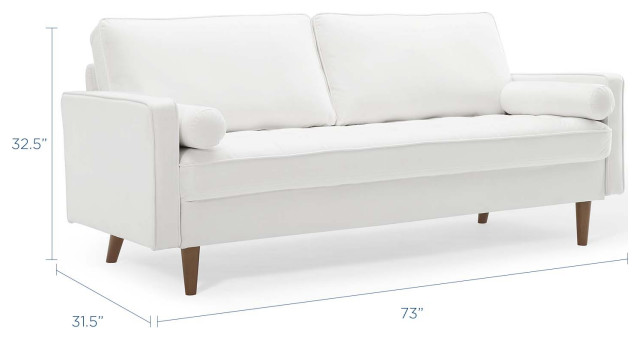

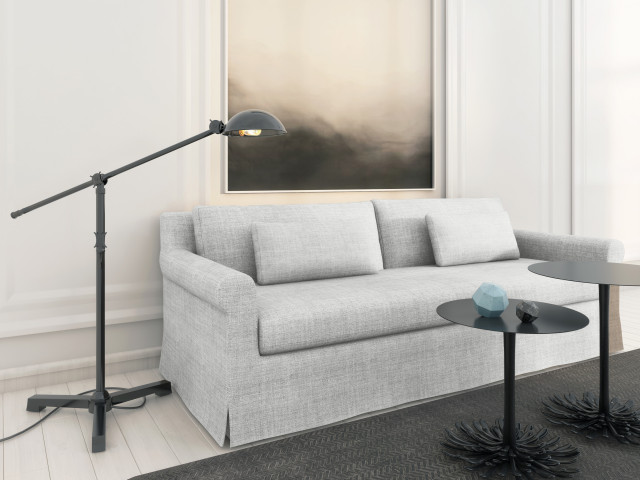

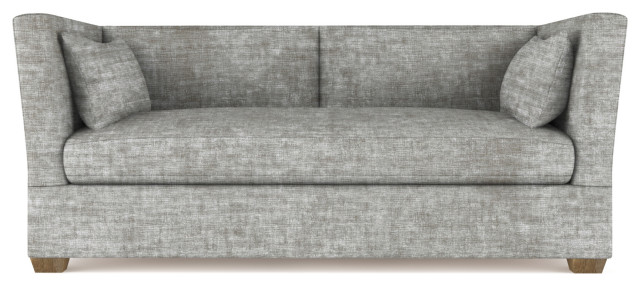

In [781]:
for i in similar:
    display(Image(filename =ssd_pictures_path/list(feature_dict.keys())[i], width=500, height=500))